In [ ]:
# switch to main dir to fix imports
import os

if os.getcwd().endswith("notebooks"):
    os.chdir("..")
    print("using project root as working dir")

In [9]:
from dataclasses import asdict
from datetime import datetime
import time
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import glob
import torch
from tqdm.notebook import tqdm
import numpy as np

from src.evaluator import Evaluator
from src.args import Args
import src.graphs as graphs

In [ ]:
# start autoreload
%load_ext autoreload
%autoreload 2

# select device
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"using {device} device")

# global seaborn settings
sns.set_context("paper")
sns.set_style("darkgrid", {"grid.color": ".8"})
palette = "Dark2"

# Load data frames


In [15]:
# load data frame from folder
path = "./out/load"
files = glob.glob(os.path.join(path, "*.csv.zip"))
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

# either replace or concat
result = df
#df_result = pd.concat((df_result, df), ignore_index=True)

In [ ]:
# save data frame
result.to_csv(os.path.join(path, "./out/saved.csv.zip"), index=False, compression=dict(method='zip', archive_name=f"data.csv"))

# Run grid search for RJS

In [10]:
# 1. configure experiment
args_list = [
    Args(
        graph_type="rgg",
        graph_size=graph_size,
        subgraph_size=subgraph_size,
        subgraph_alpha=subgraph_alpha
    )
    for graph_size in [500, 1000, 2500]
    for subgraph_size in [50, 100, 250]
    for subgraph_alpha in [0.0, 0.15, 1.0]
]
experiment_key = f"gridsearch-rgg-rjs--{datetime.now().strftime('%d-%m--%H-%M')}"
repetitions = 5

In [11]:
# 2. define how to evaluate
def evaluate(args: Args, rep: int) -> pd.DataFrame:
        graph = graphs.gen_graph(args)
        evaluator = Evaluator(
            graph=graph,
            args=args,
            writer_log_dir=f"runs/{experiment_key}/{args.graph_type}--{args.__hash__()}--{rep}",
            device=device
        )
        # train the model
        start_time = time.perf_counter()
        evaluator.train(
            optimizer=torch.optim.Adam(evaluator.net.parameters(), lr=1e-3),
            pbar=False
        )
        end_time = time.perf_counter()
        # test the model
        test_loss, test_ap, test_f1 = evaluator.test(
            epoch=args.epochs
        )
        return pd.DataFrame({
            # run meta
            "rep": rep,
            "run_time": end_time - start_time,
            # run results
            "loss": test_loss,
            "ap": test_ap,
            "f1": test_f1,
            # run args
            **asdict(args),
        })

In [12]:
# 3. run experiment
result = pd.DataFrame({})
for args, rep in tqdm([
    (args, rep)
    for args in args_list
    for rep in range(repetitions)
]):
    res = evaluate(args, rep)
    result = pd.concat([result, res], ignore_index=True)
    result.to_csv(f"./out/{experiment_key}.csv.zip", index=False, compression=dict(method='zip', archive_name=f"data.csv"))

  0%|          | 0/135 [00:00<?, ?it/s]

# Plot grid search results

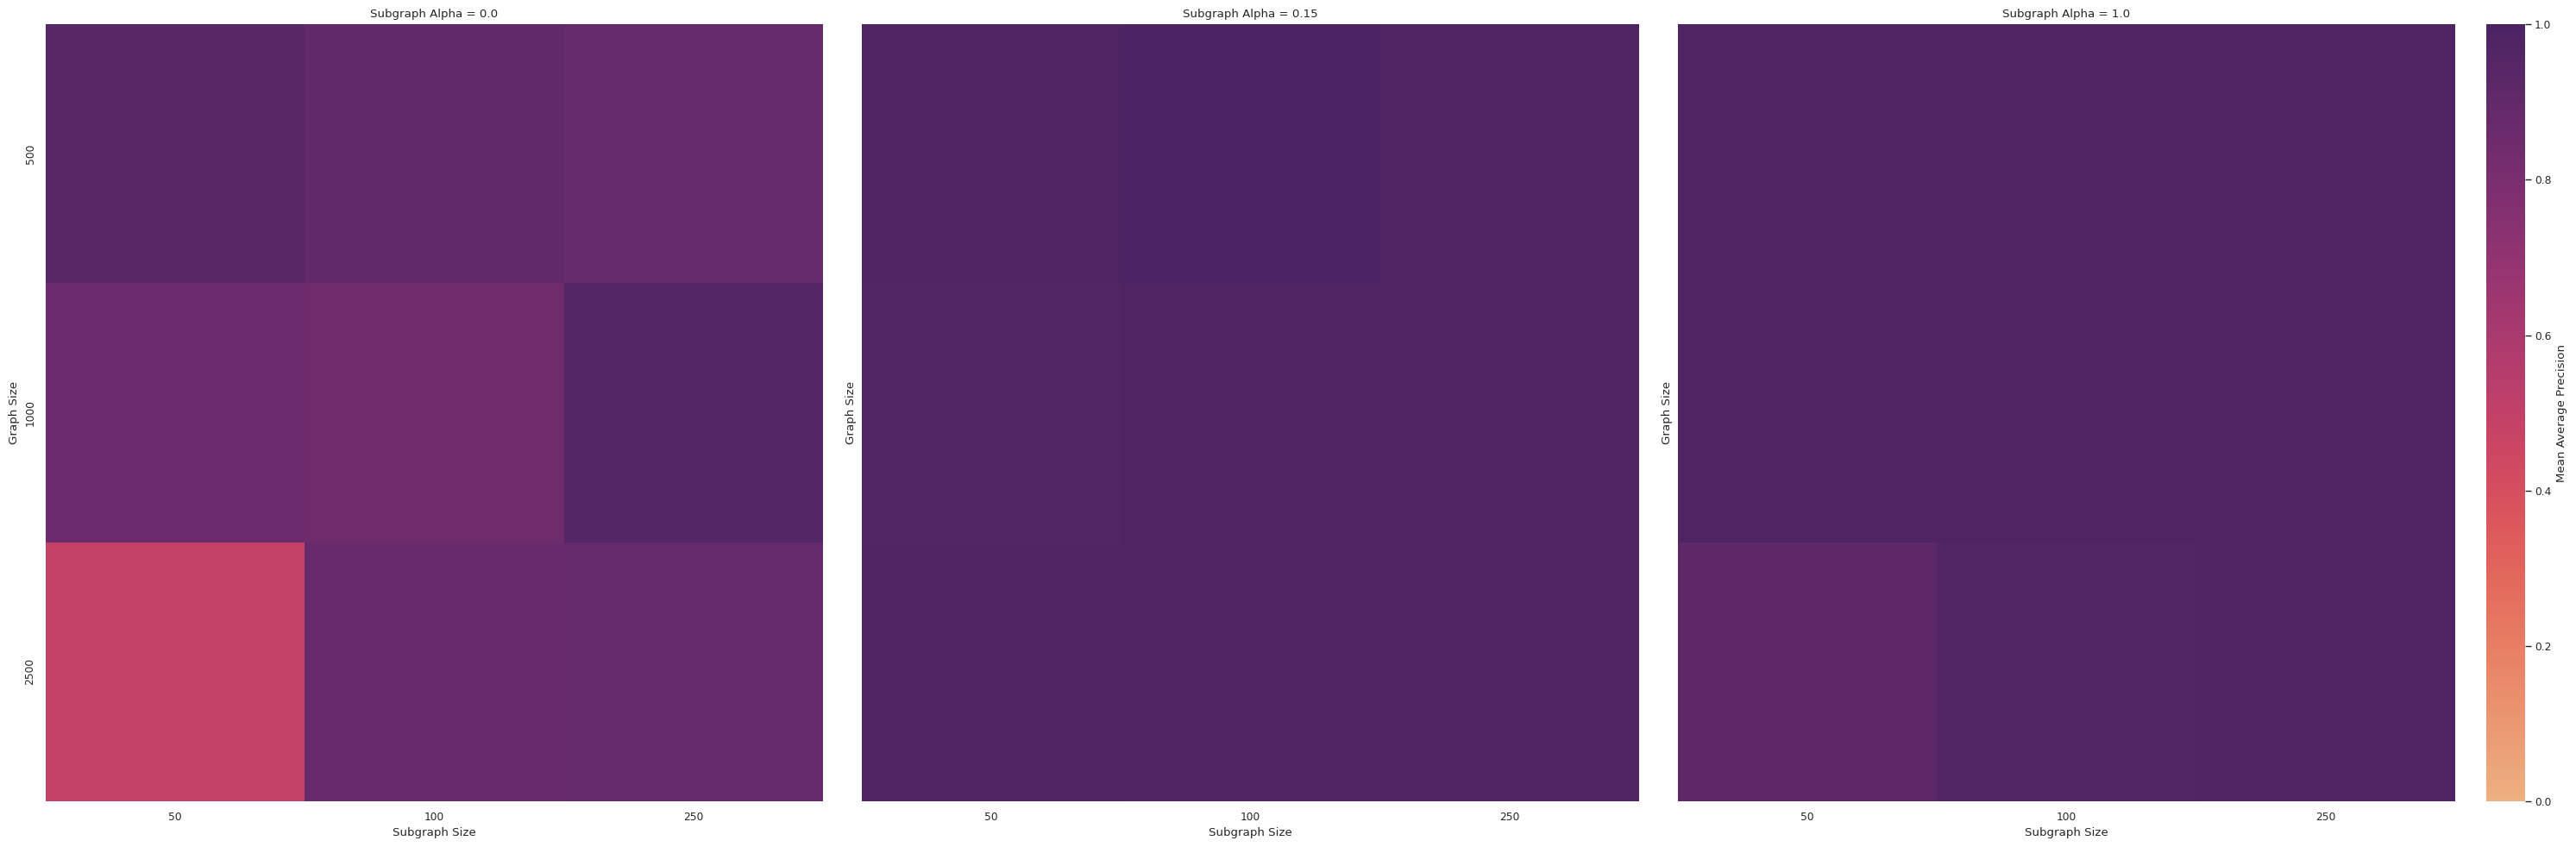

In [13]:
alphas = np.unique([args.subgraph_alpha for args in args_list])

figsize = 30
fig, axs = plt.subplots(
    ncols=len(alphas),
    figsize=(figsize, figsize / len(alphas)),
    sharey='all'
)
cbar_ax = axs[len(alphas) - 1].inset_axes([1.04, 0.0, 0.05, 1.0])
for i, a in enumerate(alphas):
    df_hm = result\
        .loc[result["subgraph_alpha"] == a]\
        .groupby(["graph_size", "subgraph_size"], as_index=False)["ap"].mean()
    g = sns.heatmap(
        vmin=0.0,
        vmax=1.0,
        data=df_hm.pivot(index="graph_size", columns="subgraph_size", values="ap"),
        ax=axs[i],
        cbar_ax=cbar_ax,
        cbar_kws={ "label": "Mean Average Precision" },
        cmap="flare",
        square=True
    )
    axs[i].set_title(f"Subgraph Alpha = {a}")
    g.set(xlabel="Subgraph Size", ylabel="Graph Size")

plt.tight_layout(pad=2)
plt.savefig('./out/grid_search.pdf')